# Types of analysis
- all explained variance analyses

# Single session

In [11]:
import numpy as np
import subjects
from neuropy.analyses import ExplainedVariance
from neuropy.analyses.neurons_stability import isi_stability, firing_rate_stability

sess = subjects.nsd.ratKday2[0]
neurons = sess.neurons.get_neuron_type("pyr")

# #---- isi stability --------
# isi_bool = isi_stability(neurons)
# stable_cells_indx = np.where(isi_bool==True)[0]
# stable_neurons = neurons[stable_cells_indx]

# ---- isi stability --------
# frate_bool =firing_rate_stability(neurons, window=2*3600)
# stable_cells_indx = np.where(frate_bool==True)[0]
# stable_neurons = neurons[stable_cells_indx]

wave_similarity = neurons.get_waveform_similarity()
pairs_bool = wave_similarity < 0.5 # only pairs which are least similar
# shank_ids = neurons.shank_ids
# pairs_bool = shank_ids.reshape(-1, 1) - shank_ids.reshape(1, -1) #cross_shanks only
pre, maze, post = sess.paradigm["pre"], sess.paradigm["maze"], sess.paradigm["post"]
pre = [0,7620]
# maze2 = sess.paradigm['re-maze']
# post = [post[0],maze2[1]]

expvar = ExplainedVariance(
    neurons=neurons,
    template=maze,
    matching=post,
    control=pre,
    slideby=300,
    pairs_bool=pairs_bool,
)


/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [6]:
sess.paradigm['pre']

array([    0.        , 10477.16663217])

<AxesSubplot:xlabel='Time (s)', ylabel='Units'>

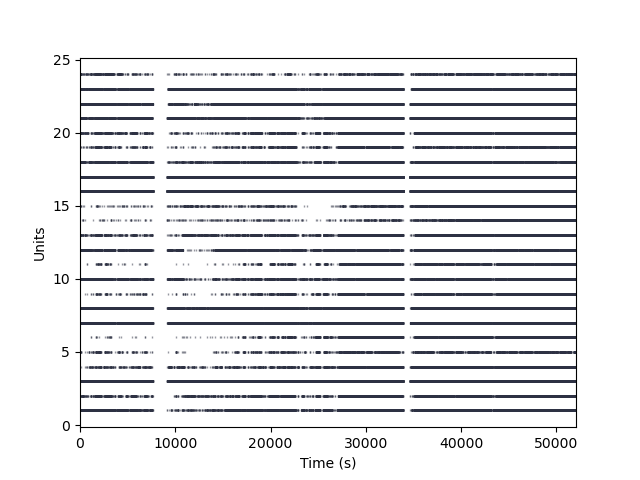

In [2]:
%matplotlib widget
from neuropy.plotting import plot_raster

plot_raster(neurons)

In [10]:
sess.neurons.firing_rate

array([ 0.27036315,  0.1657523 ,  0.57167159,  0.21945996,  0.05184441,
        0.1635625 ,  0.4281246 ,  0.30418975,  0.08874442,  0.14519894,
        0.07704629,  0.16650144,  0.18474975,  0.05856748,  0.1257981 ,
       19.31783569,  1.402911  ,  0.79017111,  8.83249023, 12.50848777,
        0.14792658,  9.63495493,  3.63865574,  0.07063057,  0.23630603,
        3.23694316,  0.27383993,  0.50653472,  0.38901559,  0.05249751])

(14239.527449737288, 51965.3)

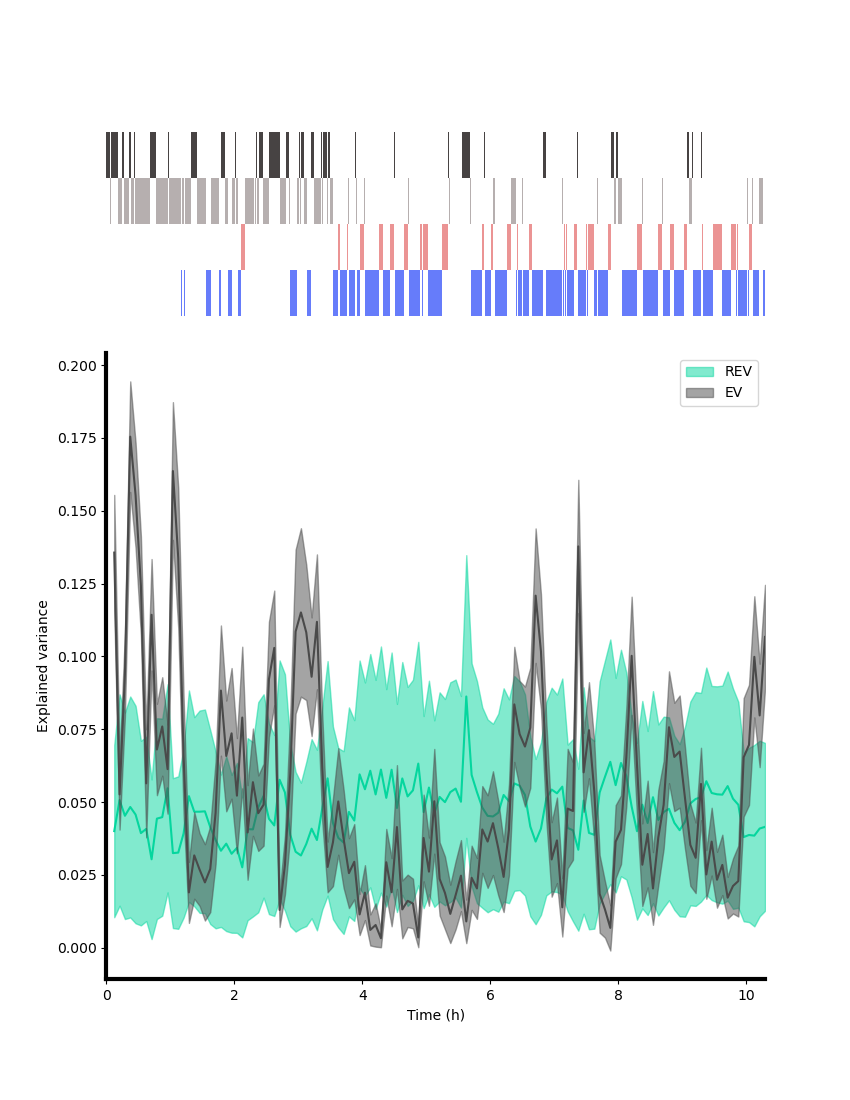

In [12]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_hypnogram,Fig

figure = Fig()
fig,gs = figure.draw(grid=(4,1),style='Pres')

ax = plt.subplot(gs[1:])
expvar.plot(ax=ax,t_start=post[0])
ax.set_xlim(left=0)
# ax.set_ylim(top=0.14)


ax = plt.subplot(gs[0])
plot_hypnogram(sess.brainstates,ax=ax)
ax.set_xlim(left = post[0])


# Plotting across multiple sessions during SD

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from neuropy.plotting import Fig
from subjects import sd,nsd
from neuropy.analyses import ExplainedVariance

sd_sessions = sd.ratNday1 + sd.ratSday3 + sd.ratRday2 + sd.ratUday4
nsd_sessions = nsd.ratNday2 + nsd.ratSday2 + nsd.ratUday2


In [ ]:
sd_expvar, nsd_expvar = [], []
for grp, sessions in enumerate([sd_sessions, nsd_sessions]):
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"]
        maze = sess.paradigm["maze"]
        if maze.size ==0:
            maze = sess.paradigm["maze1"]
        post = sess.paradigm["post"]

        neurons = sess.neurons.get_neuron_type("pyr")
        expvar = ExplainedVariance(
            neurons=neurons, template=maze, matching=post, control=pre
        )
        if grp == 0:
            sd_expvar.append(expvar)
        else:
            nsd_expvar.append(expvar)



In [ ]:
%matplotlib widget
import pandas as pd
import seaborn as sns
import numpy as np

figure = Fig()
fig,gs = figure.draw(grid=(1,1),style='Pres')

df = pd.DataFrame()
for grp,expvars in enumerate([sd_expvar,nsd_expvar]):
    for i,expvar in enumerate(expvars): 
        ev_diff = expvar.ev - expvar.rev
        ev_bins = np.arange(len(ev_diff))
        df = df.append(pd.DataFrame({'ev_diff':ev_diff,'bins':ev_bins,'grp':grp}),ignore_index=True)

ax = plt.subplot(gs[0])
sns.lineplot(data=df,x='bins',y='ev_diff',hue='grp',ci=None,ax=ax,linewidth=3,palette=['r','k'])
ax.set_ylabel('Explained variance (above chance level)')
ax.set_xlabel('ZT bins')

# Sliding template during sleep deprivation

# During recovery sleep while controlling for MAZE correlations

In [ ]:
figure = Fig()
fig, gs = figure.draw(num=1, grid=(2, 1))
sessions = subjects.sd([3])
for sub, sess in enumerate(sessions):

    maze = sess.epochs.maze1
    post = sess.epochs.post
    pre = sess.epochs.pre

    for i, hour in enumerate(range(5, 10)):
        bins = [
            # [pre[0] + 2 * 3600, pre[0] + 3 * 3600],
            # [maze[0], maze[1]],
            [post[0], post[0] + 3600],
            [post[0] + 4 * 3600, post[0] + 5 * 3600],
            [post[0] + hour * 3600, post[0] + (hour + 1) * 3600],
        ]
        # sess.spikes.stability.refPeriodViolation()
        # violations = sess.spikes.stability.violations
        sess.spikes.stability.firingRate(bins=bins)
        sess.replay.expvar.compute(
            template=bins[1],
            match=bins[2],
            control=bins[0],
        )

        axstate = gridspec.GridSpecFromSubplotSpec(
            4, 1, subplot_spec=gs[sub, i], hspace=0.2
        )

        ax1 = fig.add_subplot(axstate[1:])
        sess.replay.expvar.plot(ax=ax1, tstart=post[0])
        if sub == 0:
            ax1.set_ylim([0, 0.55])
        else:
            ax1.set_ylim([0, 0.4])

        if i > 0:
            ax1.spines["left"].set_visible(False)
            ax1.set_yticks([])
            ax1.set_yticklabels([])
            ax1.set_ylabel("")
            ax1.legend("")
            ax1.set_title("")

        axhypno = fig.add_subplot(axstate[0], sharex=ax1)
        sess.brainstates.hypnogram(ax1=axhypno, tstart=post[0], unit="h")
        # axhypno.set_title(sess.sessinfo.session.sessionName)
    # panel_label(axhypno, "a")
    # ax1.set_ylim([0, 0.3])


# Pooled by percentage above chance/REV level

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from neuropy.plotting import Fig
from subjects import sd,nsd
from neuropy.analyses import ExplainedVariance

sd_sessions = sd.ratNday1 + sd.ratSday3 + sd.ratRday2 + sd.ratUday4
nsd_sessions = nsd.ratNday2 + nsd.ratSday2 + nsd.ratUday2

In [ ]:
sd_expvar, nsd_expvar = [], []
for grp, sessions in enumerate([sd_sessions, nsd_sessions]):
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"]
        maze = sess.paradigm["maze"]
        if maze.size ==0:
            maze = sess.paradigm["maze1"]
        post = sess.paradigm["post"]

        neurons = sess.neurons.get_neuron_type("pyr")
        expvar = ExplainedVariance(
            neurons=neurons, template=maze, matching=post, control=pre
        )
        if grp == 0:
            sd_expvar.append(expvar)
        else:
            nsd_expvar.append(expvar)

# pooled explained variance across all sessions

In [ ]:
# region
sessions = subjects.Sd().allsess + subjects.Nsd().allsess
# sessions = subjects.Sd().ratJday1
corr_sd, corr_nsd = [], []
slp_sd, slp_nsd = [], []
for sub, sess in enumerate(sessions):

    pre = sess.epochs.pre
    maze = sess.epochs.maze
    if maze is None:
        maze = sess.epochs.maze1
    post = sess.epochs.post
    tag = sess.recinfo.animal.tag

    # --- break region into periods --------
    # bins = sess.utils.getinterval([post[0], post[0] + 5 * 3600], 2)
    # sess.spikes.stability.firingRate(periods=bins)
    spks = sess.spikes.pyr

    corr_maze = sess.replay.corr.pairwise(spikes=spks, period=maze)[np.newaxis, :]

    epochs = np.arange(post[0], post[0] + 8 * 3600 - 900, 300)
    corr = []
    slp_frac = []
    for i in range(len(epochs)):
        corr.append(
            sess.replay.corr.pairwise(spikes=spks, period=[epochs[i], epochs[i] + 900])
        )
        slp = sess.brainstates.proportion(period=[epochs[i], epochs[i] + 900])
        if "nrem" in slp.T:
            slp_frac.append(slp.T.nrem.values[0])
        else:
            slp_frac.append(0)

    corr = np.asarray(corr)
    slp_frac = np.asarray(slp_frac)

    corr = np.append(corr_maze, corr, axis=0)

    if tag == "sd":
        corr_sd.append(corr)
        slp_sd.append(slp_frac)
    else:
        corr_nsd.append(corr)
        slp_nsd.append(slp_frac)


def process2(corr_mat):
    corr_mat = np.hstack(corr_mat)
    corr_mask = np.ma.array(corr_mat, mask=np.isnan(corr_mat))
    corr_ = np.ma.corrcoef(corr_mask)
    np.fill_diagonal(corr_, 0)
    # corr_ = gaussian_filter(corr_, sigma=1)
    return corr_


corr_sd = process2(corr_sd)[0, 1:]
corr_nsd = process2(corr_nsd)[0, 1:]
slp_sd = np.asarray(slp_sd).mean(axis=0)
slp_nsd = np.asarray(slp_nsd).mean(axis=0)

time = np.linspace(0, 8, corr_sd.shape[0] + 1)[:-1]
width = np.diff(np.linspace(0, 8, corr_sd.shape[0] + 1))

# figure = Fig()
# fig, gs = figure.draw(num=1, grid=(4, 2))
axsd = plt.subplot(gs[3])
axslp_sd = axsd.twinx()
# axslp_sd.fill_between(
#     time, 0, slp_sd, color=sess.brainstates.colors["nrem"], alpha=0.5, zorder=1, ec=None
# )
axslp_sd.bar(
    time,
    gaussian_filter1d(slp_sd, sigma=1),
    zorder=1,
    color=sess.brainstates.colors["nrem"],
    alpha=0.4,
    width=width,
    edgecolor=None,
)

axsd.plot(time, corr_sd, "k", zorder=2)
axsd.spines["right"].set_visible(True)
axsd.set_ylabel("Correlation")
axsd.set_xlabel("Time (h)")

axnsd = plt.subplot(gs[4], sharey=axsd)
axslp_nsd = axnsd.twinx()
axslp_nsd.bar(
    time,
    gaussian_filter1d(slp_nsd, sigma=1),
    zorder=1,
    color=sess.brainstates.colors["nrem"],
    alpha=0.4,
    width=width,
    edgecolor=None,
)

axnsd.plot(time, corr_nsd, "k", zorder=2)
axnsd.set_xlabel("Time (h)")
axnsd.spines["right"].set_visible(True)
axslp_nsd.set_ylabel("nrem fraction")


figure.savefig("correlation", __file__)
# endregion


# Pooling all correlations into one vector

In [ ]:
# region
sessions = subjects.Sd().ratSday3 + subjects.Nsd().ratSday2
# sessions = subjects.Sd().ratJday1
corr_all = pd.DataFrame()
for sub, sess in enumerate(sessions):

    pre = sess.epochs.pre
    maze = sess.epochs.maze
    if maze is None:
        maze = sess.epochs.maze1
    post = sess.epochs.post
    tag = sess.recinfo.animal.tag

    # --- break region into periods --------
    # bins = sess.utils.getinterval([post[0], post[0] + 5 * 3600], 2)
    # sess.spikes.stability.firingRate(periods=bins)
    spks = sess.spikes.times
    sd_period = [post[0], post[0] + 5 * 3600]
    intervals = sess.utils.getinterval(period=sd_period, nwindows=3)
    sess.spikes.stability.firingRate(periods=intervals)
    stability = sess.spikes.stability.info
    stable_pyr = np.where((stability.q < 4) & (stability.stable == 1))[0]
    spks = [spks[cell_id] for cell_id in stable_pyr]

    pre_corr = sess.spikes.corr.pairwise(spks, pre)
    maze_corr = sess.spikes.corr.pairwise(spks, maze)
    epochs = np.arange(post[0], post[0] + 8 * 3600 - 900, 300)
    corr = []
    for start in epochs:
        corr.append(sess.spikes.corr.pairwise(spikes=spks, period=[start, start + 900]))
    corr = np.asarray(corr)

    df = pd.DataFrame(corr.T, columns=[str(_) for _ in range(len(epochs))])
    df.insert(0, "maze", maze_corr)
    df.insert(0, "pre", pre_corr)
    df.insert(0, "grp", sess.recinfo.animal.tag)
    corr_all = corr_all.append(df)

figure = Fig()
fig, gs = figure.draw(num=1, grid=[4, 3])

gs = figure.subplot2grid(gs[2, :], grid=(1, 2))

for sub, grp in enumerate(["sd", "nsd"]):
    ev, rev = [], []
    data = corr_all[corr_all.grp == grp]
    for i in range(len(epochs)):
        par_corr = pg.partial_corr(data, x="maze", y=str(i), covar="pre")
        rev_par_corr = pg.partial_corr(data, x="maze", covar=str(i), y="pre")
        ev.append(par_corr.r2.values[0])
        rev.append(rev_par_corr.r2.values[0])

    ax = plt.subplot(gs[sub])
    t = np.linspace(0, 8, data.shape[1] - 3)
    ax.plot(t, ev, color=sess.replay.expvar.colors["ev"])
    ax.plot(t, rev, color=sess.replay.expvar.colors["rev"])
    ax.set_ylim([0, 0.25])
    ax.set_ylabel("Explained variance")
    ax.set_xlabel("Time (h)")

figure.savefig("exp_var", __file__)
# endregion



# EV with shuffled cell id

In [ ]:
# region
figure = Fig()
fig, gs = figure.draw(num=1, grid=(3, 2))
sessions = (
    subjects.Nsd().ratSday2
    + subjects.Sd().ratSday3
    + subjects.Nsd().ratNday2
    + subjects.Sd().ratNday1
)
# sessions = subjects.Sd().ratSday3

for sub, sess in enumerate(sessions):

    pre = sess.epochs.pre

    try:
        maze = sess.epochs.maze
    except:
        maze = sess.epochs.maze1

    post = sess.epochs.post
    try:
        maze2 = sess.epochs.maze2
        post = [post[0], maze2[1]]
    except:
        post = post

    # --- break region into periods --------
    bins = sess.utils.getinterval([maze[0], post[1]], 5)
    sess.spikes.stability.firingRate(periods=bins)

    # template = maze
    # match = post

    sess.replay.expvar.compute_shuffle(
        template=maze, match=post, slideby=300, n_iter=100
    )
    ev = sess.replay.expvar.ev
    rev = sess.replay.expvar.rev

    axstate = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[sub], hspace=0.2)

    ax1 = fig.add_subplot(axstate[1:])
    sess.replay.expvar.plot(ax=ax1, tstart=post[0])
    ax1.set_xlim(left=0)
    ax1.tick_params(width=2)
    if sub == 3:
        ax1.set_ylim([0, 0.15])
    # # ax1.spines["right"].set_visible("False")
    # # ax1.spines["top"].set_visible("False")

    axhypno = fig.add_subplot(axstate[0], sharex=ax1)
    sess.brainstates.hypnogram(ax=axhypno, tstart=post[0], unit="h")
    # # panel_label(axhypno, "a")
    # # ax1.set_ylim([0, 11])

figure.savefig("expvar_cellid_shuffle")
# endregion


# Explained variance in recovery sleep

In [ ]:
figure = Fig()
fig, gs = figure.draw(num=1, grid=(6, 1))
sessions = subjects.Sd().ratSday3

for sub, sess in enumerate(sessions):

    sess.trange = np.array([])
    pre = sess.epochs.pre
    maze = sess.epochs.maze1
    post = sess.epochs.post

    template_periods = [
        [post[0] + _ * 3600, post[0] + (_ + 1) * 3600] for _ in range(5)
    ]

    for i, period in enumerate(template_periods):
        bins = [
            maze,
            period,
            [post[0] + 5 * 3600, post[0] + 10 * 4600],
        ]
        sess.spikes.stability.firingRate(bins=bins)
        sess.replay.expvar.compute(template=bins[1], match=bins[2], control=bins[0])

        ax1 = fig.add_subplot(gs[i + 1])
        sess.replay.expvar.plot(ax=ax1, tstart=post[0])
        ax1.set_xlim(left=0)
        ax1.set_ylim(top=0.35)
        h = np.array(period) / 3600 - post[0] / 3600
        ax1.axvspan(xmin=h[0], xmax=h[1], color="red", alpha=0.5)
        # ax1.spines["right"].set_visible("False")
        # ax1.spines["top"].set_visible("False")

    axstate = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[0], hspace=0.2)
    axhypno = fig.add_subplot(axstate[3], sharex=ax1)
    sess.brainstates.hypnogram(ax1=axhypno, tstart=post[0], unit="h")
    # panel_label(axhypno, "a")
    # ax1.set_ylim([0, 11])
